# GloVe embedding

‘glove.6B.100d.txt’ glove vectors are vectors that were pre-trained on 6 Billion tokens with 400,000 vocabulary, and a 100 dimension embedding. These vectors were applied to each token in our documents and an average of all tokens’ vectors was computed. Ultimately, each document was represented as a (1, 100) vector. In the case where no words were available in a document, a (1,100) of zeros was used instead.



In [5]:
import os
import numpy as np
import pickle
import pandas as pd
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

GLOVE_DIR = 'data/glove.6B.100d.txt'
glove_dict = {}

with open(GLOVE_DIR) as f:
    for line in f:
        word, *vector = line.split()
        glove_dict[word]=np.array(vector).astype(float)

In [6]:
def get_average_glove_vec(list_of_tokens):
    avg_vec=[]
    for token in list_of_tokens:
        if token in glove_dict:
            avg_vec.append(glove_dict[token])

    if len(avg_vec)>0:
        avg_vec = np.mean(avg_vec, axis=0)
    else:
        avg_vec = np.zeros(100)

    return avg_vec

In [9]:
import pandas as pd
df= pd.read_pickle("data/features.pkl")

In [10]:
tokenized= df['normalized']
len(tokenized)

403608

In [11]:
len(df)

403608

In [12]:
import pandas as pd
from tqdm import tqdm

#df_original = pd.read_csv("data/WikiLarge_Train.csv")
df_vecs = []

for ls in tqdm(tokenized):
    avg_vec = get_average_glove_vec(ls)
    df_vecs.append(avg_vec)

df['glove_avg'] = df_vecs

100%|██████████| 403608/403608 [00:20<00:00, 19930.68it/s]


In [13]:
X = df['glove_avg']
y = df['label']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)


In [15]:
X_train= np.vstack(X_train)
X_test= np.vstack(X_test)

# Random Forest Classifier

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = RandomForestClassifier(bootstrap= True,
 max_depth=50,
 max_features='sqrt',
 min_samples_leaf=4,
 min_samples_split=10,
 n_estimators=800)

rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

In [46]:
rf_acc = accuracy_score(y_test, rf_predictions)
print("The accuracy score is {}".format(rf_acc))

rf_f1 = f1_score(y_test, rf_predictions)
print("The F-1 score is {}".format(rf_f1))

The accuracy score is 0.6757017913332177
The F-1 score is 0.6877624045801526


In [47]:
pickle.dump(rf, open('data/glove.pkl', 'wb'))

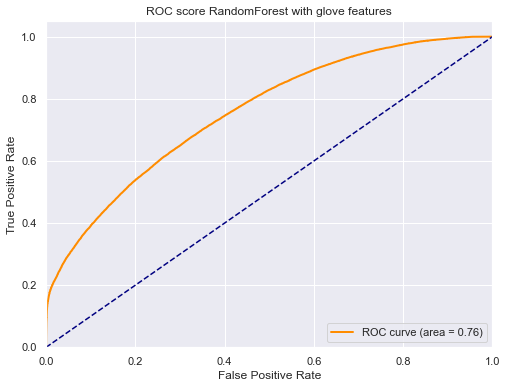

In [50]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
y_score = rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1], pos_label=1)
area = auc(fpr, tpr)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score RandomForest with glove features')
plt.legend(loc="lower right")
plt.savefig('ROC_RandomForest_glove.jpg')

# Logistic Regression

In [35]:
#For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
from sklearn.linear_model import LogisticRegression
clf= LogisticRegression(solver="sag",random_state=42)
clf.fit(X_train,np.array(y_train))

/Users/manelmahroug/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(random_state=42, solver='sag')

In [37]:
clf_preds=clf.predict(X_test)

In [40]:
f1 = f1_score(y_test,clf_preds)
clf_acc= accuracy_score(y_test, clf_preds)

In [41]:
print(f1,clf_acc)

0.5945635232083836 0.5456381160030723


In [44]:
# Grid search cross validation
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.5487850114976853


# XGBoost

In [53]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [54]:
# instantiate and fit the model
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
# get accuracy and f1 score
preds = xgb_cl.predict(X_test)
print("Accuracy score: " + str(accuracy_score(y_test, preds)))
print("F1 score: "+ str( f1_score(y_test,preds)))
      

Accuracy score: 0.6304972622085677
F1 score: 0.6669421026185025


# Gradient Boosted trees

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

glf = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 10, random_state = 42)
glf.fit(X_train, y_train.values)

GradientBoostingClassifier(learning_rate=0.05, max_depth=10, random_state=42)

In [18]:
from sklearn.metrics import accuracy_score, f1_score
glf_preds = glf.predict(X_test)
glf_acc = accuracy_score(y_test, glf_preds)
glf_f1 = f1_score(y_test, glf_preds)
glf_acc, glf_f1

(0.6502812120611481, 0.6863821183371476)

# Summary

In [19]:
# initialize list of lists
data = [['logistic_regression', 0.594,0.545638], ['random forest', 0.687762, 0.6877], \
        ['XGBoost', 0.630497, 0.6669],['Gradient boosted', 0.65028121206,0.686382]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['model', 'accuracy','f1_score'])

In [20]:
dfs1 = pd.melt(df, id_vars = "model")
dfs1.head()

,model,variable,value
0,logistic_regression,accuracy,0.594000
1,random forest,accuracy,0.687762
2,XGBoost,accuracy,0.630497
3,Gradient boosted,accuracy,0.650281
4,logistic_regression,f1_score,0.545638


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

<function matplotlib.pyplot.show(close=None, block=None)>

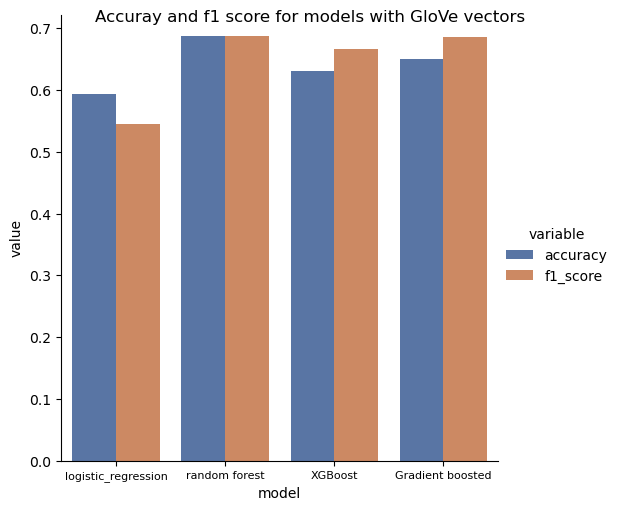

In [30]:
f= sns.catplot(x = 'model', y='value', 
               hue = 'variable',data=dfs1,palette= 'deep',kind='bar')
f.set_xticklabels(fontsize= 8)
f.fig.suptitle('Accuray and f1 score for models with GloVe vectors', fontsize= 12)


plt.show